# House Price Prediction Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
# Statistical model package
import statsmodels
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Data Exploration and Cleaning



### Identifying Numeric Data in the given dataset

In [5]:
# all numeric (float and int) variables in the dataset
df_numeric = df.select_dtypes(include=['float64', 'int64'])
# correlation matrix
cor = df_numeric.corr()
cor.style.background_gradient(cmap='coolwarm')

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

In [6]:
##############################################
# Dropping insignificant categorical variables
##############################################
# Alley has almost 94% Nulls, PoolQC has 99.5% Nulls, MiscFeature has 96.3% Nulls, 
# Fence has 80.75% Nulls, FireplaceQU has 47.2% Nulls
# Assuming these have significant % of Nulls, we can safely drop these variables

#############################
# Cleaning numeric variables
#############################
# Removing fields based on priliminary analysis
# The variables that are highly correlated
# 1. GarageArea-GarageCars have corr. of 0.894
#    The one which needs to be removed is the one that has lesser corr. with SalesPrice = GarageArea
# 2. TotRmsAbvGrd-GrLivArea have corr. of 0.824
#    The one which needs to be removed is the one that has lesser corr. with SalesPrice = TotRmsAbvGrd
# 3. 1stFlrSF-TotalBsmtSF have corr. of 0.836
#    The one which needs to be removed is the one that has lesser corr. with SalesPrice = 1stFlrSF
# 4. GarageYrBlt-YearBuilt have corr. of 0.826
#    The one which needs to be removed is the one that has lesser corr. with SalesPrice = YearBuilt
df.drop(['Id', 'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageQual', 'GarageCond', 'Heating', 'CentralAir', 'RoofMatl', 'BsmtCond', 'ExterCond', 'Functional', 'Electrical', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2', 'SaleCondition', 'Exterior2nd', 'Condition2', 'YearRemodAdd', 'OverallCond', 'GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'YearBuilt'], axis=1, inplace=True)

# For the question 3 in the subjective questions (comment after getting answer)
# df.drop(['GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF1', 'LotArea'], axis=1, inplace=True)

# Removing all data where 'LotFrontage', 'MasVnrType', 'GarageType', 'Neighborhood' are Null
df.dropna(subset=['LotFrontage', 'MasVnrType', 'GarageType', 'Neighborhood'], inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,250000


In [7]:
# Removing numeric variables that are converted to categorical later on
# 1. Removin MSSubClass, YearSold, OverallCond, OverallQual as they are later converted to categorical variables
df_numeric = df.select_dtypes(include=['float64', 'int64'])
rem_cols = ['MSSubClass', 'YrSold', 'GarageYrBlt', 'OverallQual']
df_numeric = df_numeric.drop(rem_cols, axis=1)
df_numeric.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'SalePrice'],
      dtype='object')

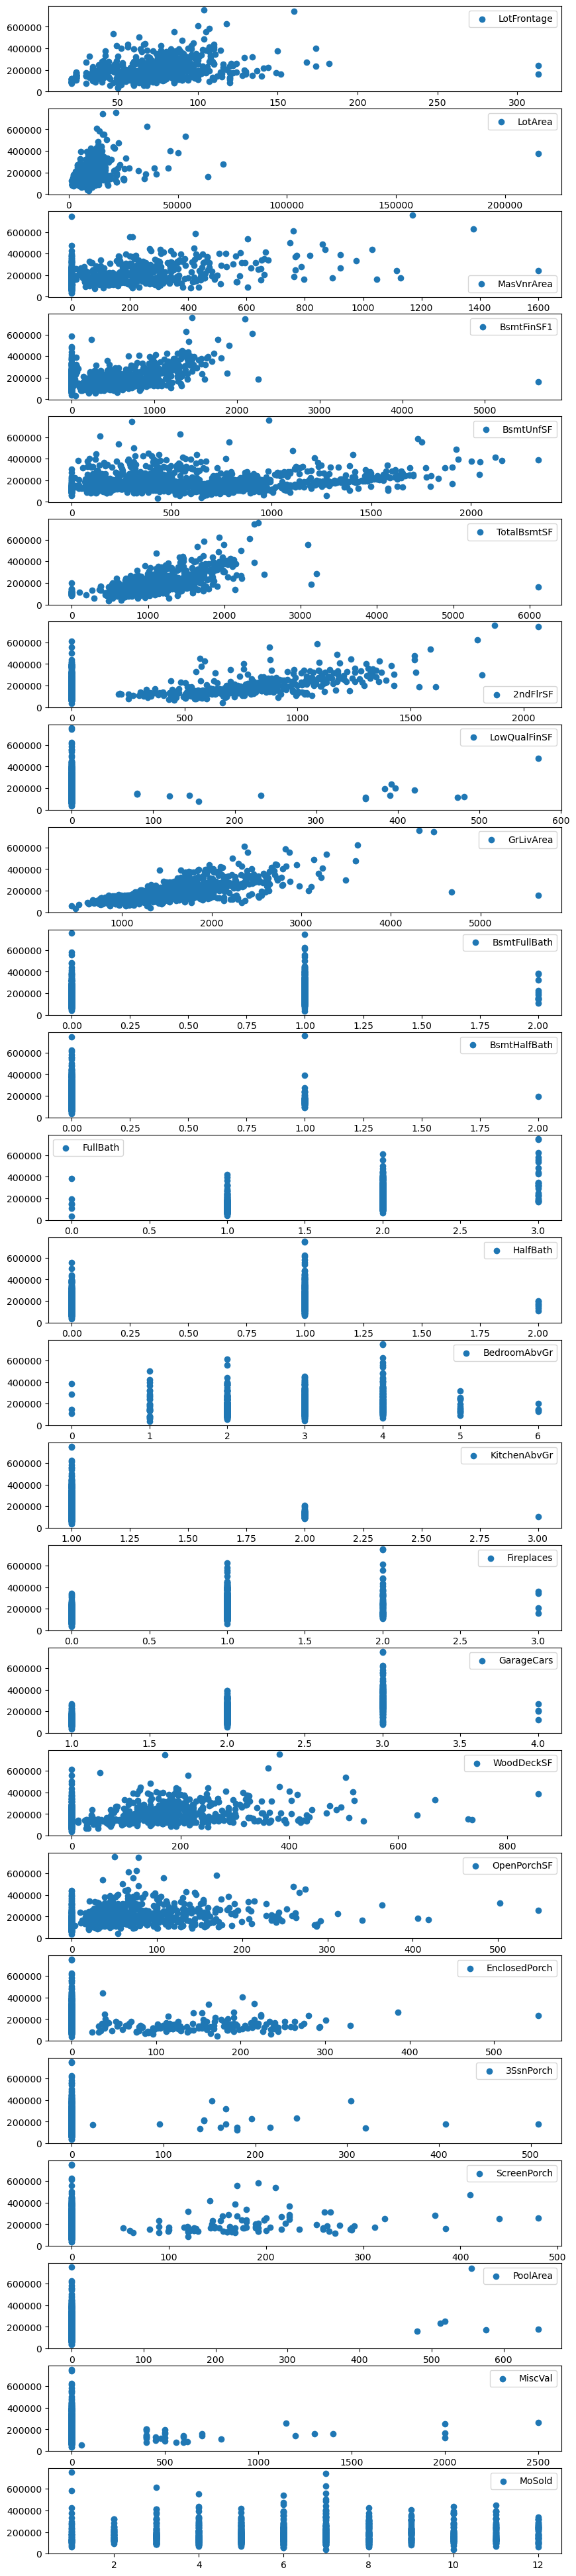

In [8]:
plt.figure(figsize=(10, 50))
for index, i in enumerate(df_numeric.columns):
    if index < 25:
        plt.subplot(25, 1, index+1)
        plt.scatter(df_numeric[i].to_list(), df_numeric['SalePrice'].to_list(), label=i)
        plt.legend()
plt.show()

### Handling Categorical Data



In [9]:
# A strategy to remove categorical variables - draw the histogram. 
# 1. The ones where you see dominance (more than say 90%) of a value can
# possibly be neglected since sale price won't get affected because almost all seem to have same feature
# 2. The ones with no-to-so dominant values (visually one can see others too substantially) - for these consider
#    as feature or not

#########################################################
# Creating Dummy variables for the categorical variables
#########################################################

############
# 1. Street
############
# Creating dummy variables (One-hot encoding) for the variables that have less number of possible values
# 1. Street - Grvl and Pave
street_type = pd.get_dummies(df['Street'], drop_first=True)
# Adding the street_type to the dataframe and removing Street variable
df = pd.concat([df, street_type], axis=1)
df.drop(['Street'], axis = 1, inplace = True)

##############
# 2. LotShape 
##############
# has values Reg, IR1,IR2,IR3
# To reduce complexity, let us map IR1,IR2,IR3 to irregular
lot_shape = {"Reg": 0, "IR1": 1, "IR2": 1, "IR3": 1}
df['lot_shape'] = df['LotShape'].map(lot_shape)
df.drop(['LotShape'], axis = 1, inplace = True)

###############
# 3. MSZoning 
###############
# has values Commercial, Floating Village Residential, Industrial, 
# Residential High Density, Residential Low Density, Residential Low Density Park , Residential Medium Density
# To reduce complexity, let us map all residential values to residential
ms_zoning = {"A":"zone_agri", "C": "zone_commercial", "FV": "zone_res", "I": "zone_res", "RH":"zone_res", "RL": "zone_res", "RP": "zone_res", "RM": "zone_res"}
df['ms_zoning'] = df['MSZoning'].map(ms_zoning)
ms_zoning_state = pd.get_dummies(df['ms_zoning'])
df = pd.concat([df, ms_zoning_state], axis=1)
df.drop(['MSZoning'], axis = 1, inplace = True)
# Since all the MSZoning is residential, we can get rid-off this variable
df.drop(['zone_res', 'ms_zoning'], axis = 1, inplace = True)

###############
# 4. LandSlope 
###############
# has values Gtl, Mod, Sev
# To reduce complexity, let us map Gtl, Mod to normal slope
land_slope = {"Sev": 1, "Mod": 0, "Gtl": 0}
df['land_slope'] = df['LandSlope'].map(land_slope)
df.drop(['LandSlope'], axis = 1, inplace = True)

##############
# 5. SaleType
##############
sale_type = {"WD":"sale_warranty", "CWD": "sale_warranty", "VWD": "sale_warranty", "new": "sale_new", "COD": "sale_deed", "Con": "sale_contract", "ConLw": "sale_contract", "ConLI": "sale_contract", "ConLD": "sale_contract", "Other": "sale_other"}
df['sale_type'] = df['SaleType'].map(sale_type)
sale_type_val = pd.get_dummies(df['sale_type'], drop_first=True)
df = pd.concat([df, sale_type_val], axis=1)
df.drop(['SaleType', 'sale_type'], axis = 1, inplace = True)

################
# 6. PavedDrive
################
# When it is either paved or partially paved, the streets are considered as paved otherwise not
# Hence, the variable "PavedDrive" can be dropped
df.drop(['PavedDrive'], axis = 1, inplace = True)

###############
# 7. Utilities 
###############
# has values AllPub, NoSewr, NoSeWa, and ELO
# To reduce complexity, let us map NoSewr, NoSeWa, and ELO to electricity
utilities = {"AllPub": 1, "NoSewr": 0, "NoSeWa": 0, "ELO": 0}
df['all_utilities'] = df['Utilities'].map(utilities)
df.drop(['Utilities'], axis = 1, inplace = True)

#####################################
# 8. Proximity to various conditions
#####################################
prox_cond = {"Artery":"prox_adj", "Feedr": "prox_adj", "Norm": "prox_normal", "RRNn": "prox_NS", "RRAn":"prox_NS", "PosA": "prox_pos", "PosN": "prox_pos", "RRNe": "prox_EW", "RRAe": "prox_EW"}
df['prox_cond'] = df['Condition1'].map(prox_cond)
prox_condition = pd.get_dummies(df['prox_cond'], drop_first=True)
df = pd.concat([df, prox_condition], axis=1)
df.drop(['Condition1', 'prox_cond'], axis = 1, inplace = True)

###############
# 9.HouseStyle
###############
# it is good enough to check if story is < 2 or >=2
house_style = {"1Story": 0, "1.5Fin": 0, "1.5Unf": 0, "2Story": 1, "2.5Fin": 1, "2.5Unf": 1, "SFoyer": 1, "SLvl": 1}
df['house_2_story'] = df['HouseStyle'].map(house_style)
df.drop(['HouseStyle'], axis = 1, inplace = True)

#####################
#. 10. Building Type
#####################
building_type = {"1Fam":"bldg_1fam", "2FmCon": "bldg_1fam", "Duplx": "bldg_duplex", "TwnshE": "bldg_town", "TwnshI":"bldg_town"}
df['building_type'] = df['BldgType'].map(building_type)
building_type_v = pd.get_dummies(df['building_type'])
df = pd.concat([df, building_type_v], axis=1)
df.drop(['BldgType', 'building_type'], axis = 1, inplace = True)

###################
# 11. LandContour
###################
# good to know if it's hillside or not
land_contour = {"Lvl": 0, "Bnk": 0, "HLS": 1, "Low": 0}
df['hillside'] = df['LandContour'].map(land_contour)
df.drop(['LandContour'], axis = 1, inplace = True)

################
# 12. LotConfig
################
# good to know if it's inside or outside
lot_config = {"Inside": 1, "Corner": 0, "CulDSac": 0, "FR2": 0, "FR3": 0}
df['lot_inside'] = df['LotConfig'].map(lot_config)
df.drop(['LotConfig'], axis = 1, inplace = True)

######################
# 13. Overall quality
######################
overall_quality = {10:"oq_above_avg", 9: "oq_above_avg", 8: "oq_above_avg", 7: "oq_above_avg", 6:"oq_above_avg", 5: "oq_avg", 4: "oq_below_avg", 3: "oq_below_avg", 2: "oq_below_avg", 1: "oq_below_avg"}
df['overall_quality'] = df['OverallQual'].map(overall_quality)
overall_quality = pd.get_dummies(df['overall_quality'], drop_first=True)
df = pd.concat([df, overall_quality], axis=1)
df.drop(['OverallQual', 'overall_quality'], axis = 1, inplace = True)

#################
# 14. GarageType
#################
# basement garage, built-in, 2Types can be considered as Attached
# car port and no garage can be considered as Detached
garage_type = {"Attchd": 1, "2Types": 1, "Basment": 1, "BuiltIn": 1, "Detchd": 0, "CarPort": 0, "NA": 0}
df['garage_attached'] = df['GarageType'].map(garage_type)
df.drop(['GarageType'], axis = 1, inplace = True)

###################
# 15. YearBuilt
###################
# Convert remodel date to categorical variable - old or new construction
# Let us consider 60 percentile as the decider to check if the construction is old or new
df['new_construction'] = df['GarageYrBlt'] >= df['GarageYrBlt'].quantile(0.6)
df['new_construction'] = df['new_construction'].map({True: 1, False: 0})
df.drop(['GarageYrBlt'], axis = 1, inplace = True)

###################
# 16. Neighborhood
###################
# Assigning directions N,E,W, NW, NE, SW, SE relative to Ames City
# Moreover, to make things more simple for the model, Consider basic directions up and down
# up = 1, down = 0
direction = {"Blmngtn": 1, "Blueste": 1, "BrDale": 1, "BrkSide": 0, "ClearCr": 1, "CollgCr": 0, "Crawfor": 0, "Edwards": 0, "Gilbert": 1, "IDOTRR": 0, "MeadowV": 0, "Mitchel": 0, "Names": 1, "NoRidge": 1, "NPkVill": 1, "NridgHt": 1, "NWAmes": 1, "OldTown": 1, "SWISU": 0, "Sawyer": 1, "SawyerW": 0, "Somerst": 1, "StoneBr": 1, "Timber": 0, "Veenker": 1}
df['nh_up'] = df['Neighborhood'].map(direction)
df.drop(['Neighborhood'], axis = 1, inplace = True)
df.dropna(subset=['nh_up'], inplace=True)

#################
# 17. Roof style
#################
# Dominant style is Gable (Seen from the histogram)
# Hence, it's sufficient to categorize the roof styles as Gable or not
roof_style = {"Gable": 1, "Hip": 0, "Gambrel": 0, "Mansard": 0, "Flat": 0}
df['roof_style_Gable'] = df['RoofStyle'].map(roof_style)
df.drop(['RoofStyle'], axis = 1, inplace = True)
df.dropna(subset=['roof_style_Gable'], inplace=True)

#######################
# 18. Basement quality
#######################
# Since dominant values are Good and Typical, the third category can be others
# Creating dummy variables for these
basement_quality = {"TA":"bsmt_typical", "Gd": "bsmt_good", "Ex": "bsmt_others", "Fa": "bsmt_others", "Po":"bsmt_others", "NA": "bsmt_others"}
df['basement_height'] = df['BsmtQual'].map(basement_quality)
basement_quality_v = pd.get_dummies(df['basement_height'])
df = pd.concat([df, basement_quality_v], axis=1)
df.drop(['BsmtQual', 'basement_height', 'bsmt_others'], axis = 1, inplace = True)

######################
# 19. Kitchen quality
######################
# Since dominant values are Good and Typical, the third category can be others
# Creating dummy variables for these
kitchen_quality = {"TA":"kitchen_typical", "Gd": "kitchen_good", "Ex": "kitchen_others", "Fa": "kitchen_others", "Po":"kitchen_others"}
df['kitchen_quality'] = df['KitchenQual'].map(kitchen_quality)
kitchen_quality_v = pd.get_dummies(df['kitchen_quality'])
df = pd.concat([df, kitchen_quality_v], axis=1)
df.drop(['KitchenQual', 'kitchen_quality', 'kitchen_others'], axis = 1, inplace = True)

################
# 20. ExterQual
################
# quality of material on the exterior
# Since dominant values are Good and Typical, the third category can be others
# Creating dummy variables for these
exter_quality = {"TA":"exter_typical", "Gd": "exter_good", "Ex": "exter_others", "Fa": "exter_others", "Po":"exter_others"}
df['exter_quality'] = df['ExterQual'].map(exter_quality)
exter_quality_v = pd.get_dummies(df['exter_quality'])
df = pd.concat([df, exter_quality_v], axis=1)
df.drop(['ExterQual', 'exter_quality', 'exter_others'], axis = 1, inplace = True)

######################
# 21. Basement Finish
######################
# Looking at the hist plot, one can categorize the basement finish into Good, Unfinished and others
bsmt_finish = {"GLQ":"bsmt_finish_good", "ALQ": "bsmt_finish_others", "BLQ": "bsmt_finish_others", "Rec": "bsmt_finish_others", "LwQ":"bsmt_finish_others", "Unf": "bsmt_unfinished", "NA": "bsmt_finish_others"}
df['bsmt_finish'] = df['BsmtFinType1'].map(bsmt_finish)
bsmt_finish_v = pd.get_dummies(df['bsmt_finish'])
df = pd.concat([df, bsmt_finish_v], axis=1)
df.drop(['BsmtFinType1', 'bsmt_finish', 'bsmt_finish_others'], axis = 1, inplace = True)

######################
# 22. Heating Quality
######################
# Since Excellent is dominant, one can categorize the heating quality as excellent or not
heating_qc = {"Ex": 1, "Gd": 0, "TA": 0, "Fa": 0, "Po": 0}
df['excellent_heating'] = df['HeatingQC'].map(heating_qc)
df.drop(['HeatingQC'], axis=1, inplace=True)

####################
# 23. Garage finish
####################
# Looking at histplot, it can be inferred that all garages are available
# Dummy variables can be created for Finished, Rough Finished, and Unfinished
garage_finish = {"Fin":"garage_finished", "RFn": "garage_rough_finished", "Unf": "garage_unfinished"}
df['garage_finish'] = df['GarageFinish'].map(garage_finish)
garage_finish_v = pd.get_dummies(df['garage_finish'])
df = pd.concat([df, garage_finish_v], axis=1)
df.drop(['GarageFinish', 'garage_finish', 'garage_finished'], axis = 1, inplace = True)

#################
# 24. Foundation
#################
# Dominant ones are Cinder block and Poured concreter. Thus others can be placed into category "others"
foundation = {"Brktil":"foundation_others", "CBlock": "foundation_cinder", "PConc": "foundation_concrete", "Slab": "foundation_others", "Stone": "foundation_others", "Wood": "foundation_others"}
df['foundation'] = df['Foundation'].map(foundation)
foundation_v = pd.get_dummies(df['foundation'])
df = pd.concat([df, foundation_v], axis=1)
df.drop(['Foundation', 'foundation', 'foundation_others'], axis = 1, inplace = True)

##########################
# 25. Masonry veneer type
##########################
# None is dominant, hence it's good enough to check if there's a type or not
mas_vnr_type = {"BrkCmn": 1, "BrkFace": 1, "CBlock": 1, "None": 0, "Stone": 1}
df['masonry_type_available'] = df['MasVnrType'].map(mas_vnr_type)
df.drop(['MasVnrType'], axis=1, inplace=True)

#################################
# 26. Exterior covering on house
#################################
# Vinyl sliding is the maximum used covering
# Hence, it's sufficient to check if covering is Vinyl or not
mas_vnr_type = {}
col = df['Exterior1st'].unique()
for key_name in col:
    if key_name == 'VinylSd':
        mas_vnr_type[key_name] = 1
    else:
        mas_vnr_type[key_name] = 0
df['vinyl_covering'] = df['Exterior1st'].map(mas_vnr_type)
df.drop(['Exterior1st'], axis=1, inplace=True)

#################
# 27. MSSubClass
#################
# Dominant subclass is 1-STORY 1946 & NEWER ALL STYLES
# Hence it is sufficient to check if subclass is 1-STORY 1946 & NEWER ALL STYLES or not
subclass = {}
col = df['MSSubClass'].unique()
for key_name in col:
    if key_name == 20:
        subclass[key_name] = 1
    else:
        subclass[key_name] = 0
df['1_Story_1946'] = df['MSSubClass'].map(subclass)
df.drop(['MSSubClass'], axis=1, inplace=True)

##################
# 28. YrSold
##################
# The year sold ranges from 2006 to 2010 and are equally distributed
# Hence, it is sufficient to check if the house is sold before 2007 or after
df['year_sold_before_2007'] = df['YrSold'] >= df['YrSold'].quantile(0.25)
df['year_sold_before_2007'] = df['year_sold_before_2007'].map({True: 1, False: 0})
df.drop(['YrSold'], axis = 1, inplace = True)

### Final dataset after cleaning and converting categorical data to dummy data which can be used for training a model

In [10]:
df.head(100)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,...,bsmt_unfinished,excellent_heating,garage_rough_finished,garage_unfinished,foundation_cinder,foundation_concrete,masonry_type_available,vinyl_covering,1_Story_1946,year_sold_before_2007
0,65.0,8450,196.0,706,150,856,854,0,1710,1,...,0,1,1,0,0,1,1,1,0,1
1,80.0,9600,0.0,978,284,1262,0,0,1262,0,...,0,1,1,0,1,0,0,0,1,1
2,68.0,11250,162.0,486,434,920,866,0,1786,1,...,0,1,1,0,0,1,1,1,0,1
3,60.0,9550,0.0,216,540,756,756,0,1717,1,...,0,0,0,1,0,0,0,0,0,0
4,84.0,14260,350.0,655,490,1145,1053,0,2198,1,...,0,1,1,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,100.0,12552,0.0,222,769,991,956,0,1947,0,...,0,1,1,0,0,1,0,1,0,1
159,134.0,19378,456.0,57,1335,1392,1070,0,2462,1,...,0,1,1,0,0,1,1,1,0,0
161,110.0,13688,664.0,1016,556,1572,1096,0,2668,1,...,0,1,0,0,0,1,1,1,0,1
162,95.0,12182,226.0,1201,340,1541,0,0,1541,0,...,0,1,1,0,0,1,1,1,1,1


In [11]:
for col in df.columns:
    if any(df[col].isnull()):
        print(col)

### Splitting the data into Training and Test set

In [12]:
# Splitting data into train and test set
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

### Dividing dataframe into dependent ('SalePrice') and independent variables

In [13]:
# Dividing dataframe into dependent variable and independent variables
# y_train = df_train.pop('SalePrice')
# X_train = df_train
# y_test = df_test.pop('SalePrice')
# X_test = df_test
y = df.pop('SalePrice') # response variable in Y
X = df

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'Pave', 'lot_shape', 'land_slope', 'sale_deed',
       'sale_warranty', 'all_utilities', 'prox_NS', 'prox_adj', 'prox_normal',
       'prox_pos', 'house_2_story', 'bldg_1fam', 'hillside', 'lot_inside',
       'oq_avg', 'oq_below_avg', 'garage_attached', 'new_construction',
       'nh_up', 'roof_style_Gable', 'bsmt_good', 'bsmt_typical',
       'kitchen_good', 'kitchen_typical', 'exter_good', 'exter_typical',
       'bsmt_finish_good', 'bsmt_unfinished', 'excellent_heating',
       'garage_rough_finished', 'garage_unfinished', 'foundation_cinder',
       'foundation_concrete', 'masonry_type_available', 'vi

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

### Linear Regression

In [15]:
# Apply scaling to the numeric columns
scaler = MinMaxScaler()
# Initial
# num_vars = ['mnth', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Subsequent Iteration
num_vars = df_numeric.columns

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,...,bsmt_unfinished,excellent_heating,garage_rough_finished,garage_unfinished,foundation_cinder,foundation_concrete,masonry_type_available,vinyl_covering,1_Story_1946,year_sold_before_2007
1106,0.577640,0.128168,0.000000,0.326549,0.079889,0.289994,0.000000,0.0,0.221848,0.5,...,0,0,0,0,0,1,0,0,1,1
176,0.472050,0.123434,0.237378,0.367699,0.148630,0.366794,0.556176,0.0,0.370549,0.0,...,0,0,0,1,0,1,1,0,0,1
779,0.354037,0.130665,0.079717,0.431416,0.000000,0.310707,0.000000,0.0,0.116458,0.5,...,0,0,0,1,1,0,1,0,0,0
643,0.366460,0.134461,0.232950,0.218142,0.000000,0.248566,0.521415,0.0,0.264678,0.0,...,0,1,0,0,1,0,1,0,0,1
107,0.180124,0.065282,0.000000,0.046018,0.239666,0.251434,0.000000,0.0,0.064726,0.0,...,0,1,0,1,1,0,0,1,1,1


In [16]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [17]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)


192822.68993368093
[ 1.43891057e+03  8.73148279e+03  4.09683576e+03  4.89121886e+03
 -3.84455135e+03  1.63792330e+04 -3.29456936e+03 -1.84119933e+02
  2.74756096e+04  1.83643108e+03 -1.14145972e+03  2.08381873e+03
  3.47322139e+03 -2.55350642e+03 -6.02239662e+03  4.93525741e+03
  8.26397928e+03  2.94118364e+03 -1.28007577e+03 -1.04242985e+03
  2.18689907e+02  4.67014127e+03  9.23708416e+01 -2.32601556e+03
 -1.97632932e+03  4.79784872e+03  1.20271143e+02 -1.64184187e+03
 -5.20024332e+03 -7.53288720e+03  9.23304385e+16  2.59383483e+03
  4.49815412e+03  6.90000000e+03 -7.19200000e+03  2.53200000e+03
  3.80600000e+03  3.86800000e+03  1.56000000e+02 -2.40600000e+03
 -5.28500000e+03 -5.78000000e+02  1.07600000e+03  2.48600000e+03
 -3.64000000e+02 -8.01400000e+03 -7.99400000e+03 -1.08197500e+04
 -1.36994062e+04 -1.09390000e+04 -1.87460000e+04  3.16475000e+03
 -7.78000000e+02  1.68600000e+03 -6.24000000e+02 -5.92000000e+02
  2.03200000e+03  4.09200000e+03 -1.52800000e+03  1.64400000e+03
 -9.52

In [18]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 score for training data = {r2_train_lr}")
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 score for test data = {r2_test_lr}")
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS for training data = {rss1_lr}")
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS for test data = {rss2_lr}")
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE for training data = {mse_train_lr}")
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE for test data = {mse_test_lr}")
metric.append(mse_test_lr**0.5)

R2 score for training data = 0.8596079323021313
R2 score for test data = 0.7174658632731143
RSS for training data = 590306115748.7201
RSS for test data = 830509105194.0732
MSE for training data = 897121756.4570215
MSE for test data = 2945067748.9151535


## Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

### Ridge Regression

In [19]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
# _l1 = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# _l2 = list(np.arange(1, 1000, 1))
# for i in _l2:
#     _l1.append(i)
# alpha_range = _l1
# params = {'alpha': alpha_range}
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5 # 5
model_cv_ridge = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_ridge.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [20]:
# Printing the best hyperparameter alpha
print(model_cv_ridge.best_params_)

{'alpha': 50}


In [21]:
#Fitting Ridge model for alpha and printing coefficients which have been penalised
alpha = model_cv_ridge.best_params_['alpha']
ridge = Ridge(alpha=2*alpha)

ridge.fit(X_train, y_train)

print(ridge.coef_)

[ 3.25229512e+03  7.05260112e+03  4.50320590e+03  7.87362125e+03
  1.41235957e+03  1.31000842e+04  3.74074395e+03  8.61581857e+02
  1.61501438e+04  2.99439729e+03 -8.24186492e+02  3.34498613e+03
  3.36018850e+03 -1.64601278e+03 -4.58508492e+03  6.14707096e+03
  8.64534369e+03  3.83412665e+03 -2.96875117e+01 -6.75646112e+02
  1.67940790e+02  4.91274834e+03  1.85735375e+01 -1.94945879e+03
 -1.40795845e+03  3.43932595e+03  1.30329964e+03 -1.11820915e+03
 -4.31375076e+03 -6.52414899e+03  0.00000000e+00  1.29281763e+01
  8.46380604e+02  2.52601704e+03 -5.33450850e+03  1.33704666e+03
  3.12891361e+03  3.59553596e+03  5.99403709e+02 -2.59849344e+03
 -4.42035474e+03  9.09864624e+02  2.32477976e+03  2.60916731e+03
 -2.06612899e+03 -7.53097975e+03 -6.39005886e+03 -6.59672011e+03
 -9.10581635e+03 -3.23774424e+03 -9.62887785e+03  3.31718457e+03
 -1.52850044e+03  2.92202383e+03 -1.68513417e+03 -1.98563507e+03
 -3.29838839e+02  2.85599298e+03  9.41071290e+01  9.20329184e+01
  9.09110131e+02  1.70737

In [22]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 score for training data = {r2_train_lr}")
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 score for test data = {r2_test_lr}")
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS for training data = {rss1_lr}")
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS for test data = {rss2_lr}")
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE for training data = {mse_train_lr}")
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE for test data = {mse_test_lr}")
metric2.append(mse_test_lr**0.5)

R2 score for training data = 0.8504197992945479
R2 score for test data = 0.7327966110090095
RSS for training data = 628939431687.6335
RSS for test data = 785444371666.3076
MSE for training data = 955835002.5647926
MSE for test data = 2785263729.3131475


### Lasso Regression

In [23]:
lasso = Lasso()

# cross validation
model_cv_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_lasso.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [24]:
# Printing the best hyperparameter alpha
print(model_cv_lasso.best_params_)

{'alpha': 500}


In [25]:
#Fitting Ridge model for alpha and printing coefficients which have been penalised

alpha = model_cv_lasso.best_params_['alpha']

lasso = Lasso(alpha=2*alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=1000)

In [26]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(f"R2 score for training data = {r2_train_lr}")
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(f"R2 score for test data = {r2_test_lr}")
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(f"RSS for training data = {rss1_lr}")
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(f"RSS for test data = {rss2_lr}")
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(f"MSE for training data = {mse_train_lr}")
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(f"MSE for test data = {mse_test_lr}")
metric3.append(mse_test_lr**0.5)

R2 score for training data = 0.8503992726328247
R2 score for test data = 0.7233931506238509
RSS for training data = 629025740082.0455
RSS for test data = 813085843810.8057
MSE for training data = 955966170.3374553
MSE for test data = 2883283134.080871


In [27]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),8.596079e-01,8.504198e-01,8.503993e-01
1,R2 Score (Test),7.174659e-01,7.327966e-01,7.233932e-01
2,RSS (Train),5.903061e+11,6.289394e+11,6.290257e+11
3,RSS (Test),8.305091e+11,7.854444e+11,8.130858e+11
4,MSE (Train),2.995199e+04,3.091658e+04,3.091870e+04
5,MSE (Test),5.426848e+04,5.277560e+04,5.369621e+04


### Observing changes in coefficients after regularization

In [28]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
LotFrontage,1.438911e+03,3252.295117,1463.090006
LotArea,8.731483e+03,7052.601120,6689.373926
MasVnrArea,4.096836e+03,4503.205903,3684.385345
BsmtFinSF1,4.891219e+03,7873.621247,9046.563393
BsmtUnfSF,-3.844551e+03,1412.359575,-0.000000
TotalBsmtSF,1.637923e+04,13100.084164,14284.829587
2ndFlrSF,-3.294569e+03,3740.743945,0.000000
LowQualFinSF,-1.841199e+02,861.581857,-0.000000
GrLivArea,2.747561e+04,16150.143819,25626.537456
BsmtFullBath,1.836431e+03,2994.397286,969.738231


In [29]:
b1 = betas[betas['Lasso'] != 0]
b1['Lasso']

LotFrontage               1463.090006
LotArea                   6689.373926
MasVnrArea                3684.385345
BsmtFinSF1                9046.563393
TotalBsmtSF              14284.829587
GrLivArea                25626.537456
BsmtFullBath               969.738231
FullBath                   334.614470
HalfBath                  2791.471904
BedroomAbvGr              -857.383814
KitchenAbvGr             -6117.334189
Fireplaces                5145.089406
GarageCars                9798.824921
WoodDeckSF                2717.428194
ScreenPorch               3552.699818
MiscVal                  -1260.669006
MoSold                    -700.588195
Pave                      3362.212303
lot_shape                  140.523075
land_slope                -122.401078
sale_deed                -4127.995775
sale_warranty            -6056.229929
prox_normal               1344.857051
prox_pos                 -6426.670328
house_2_story              346.833863
bldg_1fam                 1959.724984
hillside    

In [30]:
b1.max()

Linear    27475.609624
Ridge     16150.143819
Lasso     25626.537456
dtype: float64

In [31]:
betas['Ridge'].max()

16150.143818809438

In [32]:
len(b1['Lasso'])

44

In [33]:
len(betas['Ridge'])

62

In [34]:
b1['Lasso'].sort_values(ascending=False)

GrLivArea                25626.537456
TotalBsmtSF              14284.829587
GarageCars                9798.824921
BsmtFinSF1                9046.563393
LotArea                   6689.373926
Fireplaces                5145.089406
MasVnrArea                3684.385345
hillside                  3557.417024
ScreenPorch               3552.699818
Pave                      3362.212303
bsmt_finish_good          3113.622822
HalfBath                  2791.471904
WoodDeckSF                2717.428194
new_construction          1994.226247
bldg_1fam                 1959.724984
nh_up                     1942.981757
foundation_concrete       1900.209368
LotFrontage               1463.090006
excellent_heating         1406.607177
prox_normal               1344.857051
year_sold_before_2007     1244.400978
BsmtFullBath               969.738231
house_2_story              346.833863
FullBath                   334.614470
lot_shape                  140.523075
garage_attached            107.817772
land_slope  